# Establishing a stability on the news title with quorum

## Problem

- LLM's are not deterministic, and the news title is not stable. This can cause news headlines to change between runs.
- Different LLM models have different biases, and can censor or amplify certain news sources or topics regardless of the input.

## Solution

Use multiple LLM models to generate news titles, and select the most common one as the final title.

## Approach

– Generate news titles using multiple LLM models.
– Generate sentence vectors for each headline using sentence-transformers.
- Calculate the cosine similarity between each pair of titles.
- If the similarity is above a certain threshold, consider the titles to be the same, and select the title with the highest quorum.
- Cluster the titles based on the similarity, and select the cluster with the highest number of titles as group.
- Rank the group members based on suitability:
  - NER analysis – check headline against entities identified in the article
  - TD-IDF analysis - check headline against most "impactful" words from the article
  - l2 distance to the article using sentence-transformers
  - l2 distance to the cluster center.


## TODO
Universal Sentence Encoder

Extract Quantitative Features with tools like TextBlob or VADER:
 - Polarity: A score ranging from -1 (negative) to 1 (positive). Headlines with extreme values may indicate bias.
 - Subjectivity: A score from 0 (very objective) to 1 (very subjective). Lower subjectivity often suggests a more neutral tone.


In [1]:
%load_ext autoreload
%autoreload 2

from meri.utils import setup_logging

import logging

setup_logging()
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("trafilatura").setLevel(logging.DEBUG)


## Approach testing – similarity

Test sentence tranformers and clustering methods against static data.

Notice that this dataset is a bad example, as the event is most likely in different datasets.

In [2]:
# Test data
headlines = [
    # emphasizes the student movement and its suppression.
    "Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown",
    # focuses on the military’s role in ending the protests.
    "Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations",
    # ses stronger language ("Massacre") to highlight the violence and casualties.
    "1989 Tiananmen Square Massacre: Government Forces Clash with Protesters in Beijing"
]

alternative_headlines = [
    # emphasizing the student-led movement and military response.
    "Tiananmen Square 1989: Student Protests Met with Military Force in Beijing",
    # focusing on military suppression.
    "Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square",
    # emphasizing the violent clash.
    "Tiananmen Square Massacre: Government Troops Open Fire on Protesters in 1989"
]

wording_variants = [
    # emphasizing the student-led movement and crackdown.
    "1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention",
    # focusing on the military suppression of demonstrators.
    "Chinese Troops Disperse Pro-Democracy Protesters in Tiananmen Square, 1989",
    # highlighting government force and violence.
    "Tiananmen Square Tragedy: Beijing Crackdown on Protesters Turns Violent in 1989"
]

approved_headlines = [
    "Beijing Restores Order After Unrest in Tiananmen Square",
    "Chinese Authorities Take Decisive Action to End Riots in Capital",
    "Government Ensures National Stability Amid Social Disturbance in 1989",
]

allok_headlines = [
    # a normal government action with no disruption.
    "Routine Security Measures Implemented in Beijing, Daily Life Unaffected",
    # Implying no major event took place.
    "Calm Prevails in Tiananmen Square as Citizens Go About Their Day",
    # Downplays the scale and significance of the protests.
    "Beijing Maintains Social Harmony Amid Minor Public Gatherings"
]

offtopic_headlines = [
    "China Hosts International Conference on Climate Change",
    "Aliens Land in Beijing, Establish Contact with Chinese Government",
    "Trump Announces New Sanctions on Chinese Imports, Beijing Responds with retaliatory Tariffs",
]

article = """
Beijing – What began as a peaceful student-led movement advocating for political reform and greater freedoms ended in a violent military crackdown as Chinese government forces moved into Tiananmen Square in the early hours of June 4.

For weeks, tens of thousands of demonstrators, including students, intellectuals, and workers, had occupied the square, calling for democratic reforms, freedom of speech, and an end to government corruption. The protests, initially sparked by the death of pro-reform leader Hu Yaobang, grew into one of the largest demonstrations in China’s history.

"As a student, I felt that we had a unique opportunity to bring about real change," said Liu Wei, a university student who participated in the protests. "We wanted our voices to be heard and to see a brighter future for our country."

As negotiations between protesters and the government stalled, authorities declared martial law. On the night of June 3 and into June 4, the Chinese military, equipped with tanks and armed troops, advanced on Tiananmen Square. Eyewitnesses reported gunfire, chaotic clashes, and casualties among unarmed civilians. While the exact death toll remains disputed, estimates range from several hundred to possibly thousands.

"It was a nightmare. I saw people getting shot and trampled in the chaos," recalled Chen Ming, a witness to the events. "The square, once filled with hope and solidarity, turned into a scene of horror."

Official statements from the Chinese government at the time described the crackdown as necessary to "restore order." Li Peng, the Premier of China, stated, "The measures taken were essential to ensure the stability and unity of our nation. The government had no choice but to act decisively in the face of chaos and insurrection."

The Chinese government has since suppressed discussion of the events, censoring information in media and online platforms. The incident remains a highly sensitive topic in China, while globally, it stands as a symbol of the struggle for democratic rights and government accountability.

"We lost so many friends and colleagues that night," said Wang Mei, a former protester and now a human rights advocate. "But their sacrifice will not be forgotten. The world must remember what happened and continue to fight for the values we stood for."
"""

grouped_headlines = {
    "Headlines": headlines,
    "Alternative Headlines": alternative_headlines,
    "Wording Variants": wording_variants,
    "Approved Headlines": approved_headlines,
    "All-OK Headlines": allok_headlines,
    "Off-Topic Headlines": offtopic_headlines
}

aspected_headlines = {
    "Student Movement": [headlines[0], alternative_headlines[0], wording_variants[0]],
    "Military Suppression": [headlines[1], alternative_headlines[1], wording_variants[1]],
    "Violent Clash": [headlines[2], alternative_headlines[2], wording_variants[2]]
}

headlines_list = headlines + alternative_headlines + wording_variants + approved_headlines + allok_headlines + offtopic_headlines


In [3]:
# Setup sentence-transformers
# Install sentence-transformers
#!pip install torch --index-url https://download.pytorch.org/whl/cpu
#!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()


In [4]:
import numpy as np

def mean_cosine_similarity(similarities):
    # Calculate the average cosine similarity between the headlines
    # Drop all diagonal values (i.e., self-similarities)
    mask = ~np.eye(similarities.shape[0], dtype=bool)
    return similarities[mask].mean()

def comp_similarity(headlines_list):
    """
    Compute the average similarity between all headlines.
    """

    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)
    print(f"There is a total of {embeddings.shape[0]} headlines and each headline is represented by a {embeddings.shape[1]}-dimensional vector.")

    # Compute cosine similarities between headlines
    similarities = model.similarity(embeddings, embeddings)
    average_similarity = mean_cosine_similarity(similarities)
    print(f"The average cosine similarity between the headlines is {average_similarity:.2f}.")


def comp_group_similarity():
    """
    Similarity between headlines within each group and aspect.
    """

    # Compute embeddings for each group of headlines
    grouped_embeddings = {k: model.encode(v, show_progress_bar=False) for k, v in grouped_headlines.items()}
    print("\nSimilarity between headlines within each group:")
    # Compute cosine similarities between headlines within each group
    grouped_similarities = {k: model.similarity(v, v) for k, v in grouped_embeddings.items()}
    for group, similarities in grouped_similarities.items():
        group_mean = mean_cosine_similarity(similarities)
        print(f" - {group}: {group_mean:.2f}")

    # Compute for each aspect
    aspect_embeddings = {k: model.encode(v, show_progress_bar=False) for k, v in aspected_headlines.items()}
    aspect_similarities = {k: model.similarity(v, v) for k, v in aspect_embeddings.items()}
    print("\nSimilarity between headlines within each aspect:")
    for aspect, similarities in aspect_similarities.items():
        aspect_mean = mean_cosine_similarity(similarities)
        print(f" - {aspect}: {aspect_mean:.2f}")

comp_similarity(headlines_list)
comp_group_similarity()

There is a total of 18 headlines and each headline is represented by a 384-dimensional vector.
The average cosine similarity between the headlines is 0.48.

Similarity between headlines within each group:
 - Headlines: 0.74
 - Alternative Headlines: 0.74
 - Wording Variants: 0.79
 - Approved Headlines: 0.34
 - All-OK Headlines: 0.43
 - Off-Topic Headlines: 0.36

Similarity between headlines within each aspect:
 - Student Movement: 0.91
 - Military Suppression: 0.78
 - Violent Clash: 0.89


In [34]:
def sort_by_similarity(headlines: list):
    """
    Sort headlines by similarity centrality.
    """
    embeddings = model.encode(headlines, show_progress_bar=False)
    center_mode = np.mean(embeddings, axis=0)
    closeness = model.similarity(center_mode, embeddings)
    return sorted(zip(headlines, closeness[0]), key=lambda x: x[1], reverse=True)

print("Closeness of headlines to the center of the Student Movement aspect:")
for headline, similarity in sort_by_similarity(aspected_headlines['Student Movement']):
    print(f" - {headline}: {similarity:.2f}")


Closeness of headlines to the center of the Student Movement aspect:
 - 1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention: 0.98
 - Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown: 0.97
 - Tiananmen Square 1989: Student Protests Met with Military Force in Beijing: 0.96


In [29]:
# Calculate similarity between the article and the headlines
article_embedding = model.encode([article], show_progress_bar=False)
article_similarities = model.similarity(article_embedding, model.encode(headlines_list, show_progress_bar=False))
article_mean_similarity = article_similarities.mean()

print(f"\nSimilarity between the article and the headlines: {article_mean_similarity:.2f}")

sorted_headlines = sorted(zip(headlines_list, article_similarities[0]), key=lambda x: x[1], reverse=True)

for headline, similarity in sorted_headlines:
    print(f" - {headline}: {similarity:.2f}")


Similarity between the article and the headlines: 0.57
 - Tiananmen Square 1989: Student Protests Met with Military Force in Beijing: 0.79
 - Tiananmen Square Tragedy: Beijing Crackdown on Protesters Turns Violent in 1989: 0.77
 - 1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention: 0.76
 - 1989 Tiananmen Square Massacre: Government Forces Clash with Protesters in Beijing: 0.75
 - Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown: 0.74
 - Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square: 0.71
 - Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations: 0.71
 - Chinese Troops Disperse Pro-Democracy Protesters in Tiananmen Square, 1989: 0.70
 - Calm Prevails in Tiananmen Square as Citizens Go About Their Day: 0.69
 - Tiananmen Square Massacre: Government Troops Open Fire on Protesters in 1989: 0.69
 - Beijing Restores Order After Unrest in Tiananmen Square: 0.66
 - Chinese Aut

### Approach testing – Clustering

Test clustering methods against static data.

KMeans Clustering:
Optimal number of clusters: 4 (Elbow Method) / 2 (Silhouette Score)
Optimal number of clusters differ between the elbow method and silhouette score.


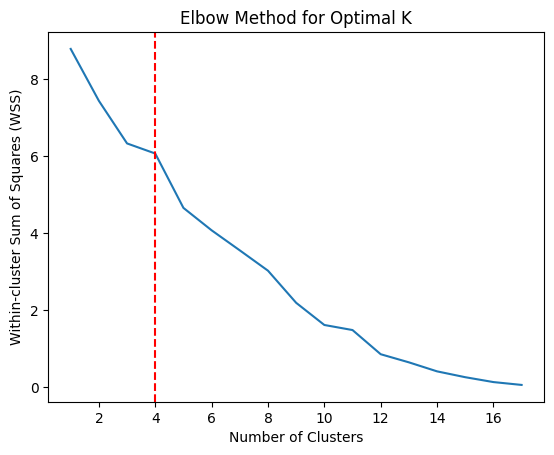

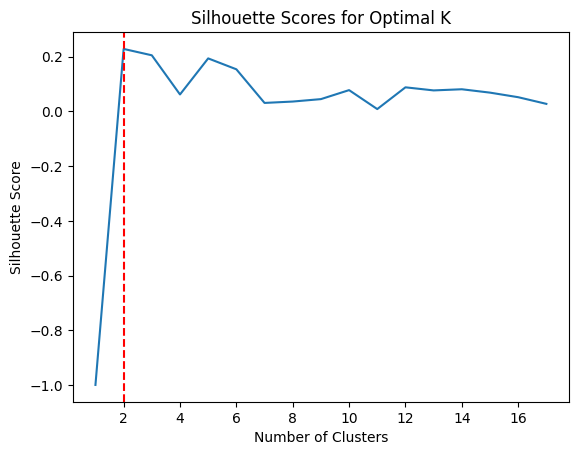

In [6]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

MIN_NUM_CLUSTERS = 1
MAX_NUM_CLUSTERS = len(headlines_list) - 1

def kmeans_cluster():
    """
    Cluster the headlines using KMeans.
    """
    
    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)

    # Determine the optimal number of clusters
    clusters = []
    inertias = []
    silhouettes = [-1]
    for i in range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++')
        cluster_labels = kmeans.fit_predict(embeddings)
        clusters.append(cluster_labels)
        inertias.append(kmeans.inertia_)

        # Skip silhouette score for 1 cluster
        if i == 1: continue

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouettes.append(silhouette_avg)

    # Find the optimal number of clusters using the elbow method
    elbow = np.diff(inertias)
    opt_elbow = elbow.argmin() + 1

    # Optimal using silhouette score
    opt_silh = silhouettes.index(max(silhouettes)) + 1

    print(f"Optimal number of clusters: {opt_elbow} (Elbow Method) / {opt_silh} (Silhouette Score)")

    # If the optimals are the same, show the clustering results
    if opt_elbow == opt_silh:
        print(f"Clustering headlines into {opt_elbow} clusters:")
        for i in range(opt_elbow):
            cluster = np.array(headlines_list)[clusters[opt_elbow] == i]
            print(f"Cluster {i + 1}: {cluster}")
    else:
        print("Optimal number of clusters differ between the elbow method and silhouette score.")
    
    # Plot the inertia values
    plt.plot(range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1), inertias)
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.axvline(opt_elbow, linestyle='--', color='r', label='Optimal K')
    plt.show()

    # Plot the silhouette scores
    plt.plot(range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1), silhouettes)
    plt.title('Silhouette Scores for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.axvline(opt_silh, linestyle='--', color='r', label='Optimal K')
    plt.show()


print("KMeans Clustering:")
kmeans_cluster()


In [7]:
from collections import Counter
from sklearn.cluster import DBSCAN

def dbscan_cluster():
    """
    Cluster the headlines using DBSCAN.
    """

    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.2, min_samples=2, metric="cosine")
    labels = dbscan.fit_predict(embeddings)
    print("DBSCAN Labels:", labels)

    # Get the number of clusters
    num_clusters = Counter(labels)
    print(f"Number of clusters: {len(num_clusters)}")

    # Return the clustering results
    clusters = []
    for i in range(-1, len(num_clusters)-1):
        cluster = np.array(headlines_list)[labels == i]
        print(f"Cluster {i}: {cluster}")

        # Ignore noise points (label -1)
        if i == -1: continue
        clusters.append(cluster)

    return clusters

    
print("DBSCAN Clustering:")
r = dbscan_cluster()

# Select the largest cluster, and compute the relative size to the total number of headlines
largest_cluster = max(r, key=len)
relative_size = len(largest_cluster) / len(headlines_list)
print("")
print(f"Largest Cluster size {len(largest_cluster)} ({relative_size:.2%}%))")


DBSCAN Clustering:
DBSCAN Labels: [ 0 -1  0  0 -1  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Number of clusters: 2
Cluster -1: ["Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations"
 'Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square'
 'Beijing Restores Order After Unrest in Tiananmen Square'
 'Chinese Authorities Take Decisive Action to End Riots in Capital'
 'Government Ensures National Stability Amid Social Disturbance in 1989'
 'Routine Security Measures Implemented in Beijing, Daily Life Unaffected'
 'Calm Prevails in Tiananmen Square as Citizens Go About Their Day'
 'Beijing Maintains Social Harmony Amid Minor Public Gatherings'
 'China Hosts International Conference on Climate Change'
 'Aliens Land in Beijing, Establish Contact with Chinese Government'
 'Trump Announces New Sanctions on Chinese Imports, Beijing Responds with retaliatory Tariffs']
Cluster 0: ['Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military 

### Approach testing – Relevancy

From the dataset, find the most relevant title to the article content.


#### Cross-Encoding

As a variation to sentence-transformers, use cross-encoding to compare the generated titles with the article content.

In [8]:
from sentence_transformers.cross_encoder import CrossEncoder

# Load the CrossEncoder model
#cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device="cpu")
cross_encoder = CrossEncoder("BAAI/bge-reranker-v2-m3", device="cpu")

ranked = cross_encoder.rank(article, headlines_list)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
print("Cross-Encoder Ranking:")
for e in ranked:
    _headline = headlines_list[e['corpus_id']]
    print(f" - {_headline}: {e['score']:.2f}")

Cross-Encoder Ranking:
 - Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown: 0.99
 - 1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention: 0.98
 - Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square: 0.98
 - Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations: 0.97
 - Tiananmen Square 1989: Student Protests Met with Military Force in Beijing: 0.97
 - Tiananmen Square Tragedy: Beijing Crackdown on Protesters Turns Violent in 1989: 0.90
 - Calm Prevails in Tiananmen Square as Citizens Go About Their Day: 0.76
 - Beijing Restores Order After Unrest in Tiananmen Square: 0.73
 - 1989 Tiananmen Square Massacre: Government Forces Clash with Protesters in Beijing: 0.70
 - Trump Announces New Sanctions on Chinese Imports, Beijing Responds with retaliatory Tariffs: 0.63
 - Routine Security Measures Implemented in Beijing, Daily Life Unaffected: 0.61
 - Chinese Troops Disperse Pro-Demo

#### Approach testing – NER

Named Entity Recognition (NER) can identify important people, places, organizations, and events in the article. As good headlines should include "who" and "what," NER can help ensure key subjects are included.

In theory this should help to ensures key subjects are included (e.g., if all headlines miss an important figure or place) or if the genenrated headline is missing a key subject or significant player, due to oversight or bias. But as we try to include more general affiliations and roles instead of just names, using specific entities to see if the headline is missing a key player can prove to be a challenge. e.g., we try to use "Prime minister" instead of "Petteri Orpo", but the extracted entities might only include the latter. In the future we could try to use the knowledge graph to find entity relations and map article entities to the headline entities.

In [10]:
# !pip install spacy -q
# !python -m spacy download en_core_web_sm
import spacy

# entities that attempt to answer the question _who_, _what_, _when_, _where_, _why_, or _how_
ENTITIES = ["PERSON", "ORG", "GPE", "EVENT", "DATE", "TIME", "LOC", "FAC", "WORK_OF_ART"]

# Load a pre-trained NER model
nlp = spacy.load("en_core_web_sm")

doc = nlp(article)

# # All entities and their labels
# article_entities = [(ent.text, ent.label_) for ent in doc.ents]
# print("All Entities:", article_entities)

key_entities = [ent.text for ent in doc.ents if ent.label_ in ENTITIES]

# Get unique entities
key_entities = list(set(key_entities))
print("Key Entities from article:", key_entities)


Key Entities from article: ['Beijing', 'China', 'weeks', 'Hu Yaobang', 'the night of June 3', 'that night', 'Wang Mei', 'Liu Wei', 'June 4', 'Chen Ming', 'the early hours of', 'Tiananmen Square', 'Li Peng']


In [11]:
def lemmaize(text: str) -> str:
    """
    Lemmatize a given text.

    Lemma is the base form of a word. For example, the lemma of "running" is "run".
    """
    # Parse the text
    doc = nlp(text)
    # Lemmatize each token
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

# Extract entities from headlines
def extract_entities(headlines: list[str]) -> list[list[str]]:
    """
    Extract entities from a list of headlines.
    """

    # Initialize a list to store entities for each headline
    headline_entities = []

    # Process each headline
    for headline in headlines:
        # Parse the headline
        doc = nlp(headline)
        # Extract entities
        entities = [ent.text for ent in doc.ents if ent.label_ in ENTITIES]
        headline_entities.append(entities)

    return headline_entities


def process_headlines(headlines: list[str], article_entities: list[str]) -> list[tuple[str, float, set[str]]]:
    """
    Process headlines and rank them based on entity matching with the article.

    Returns a list of tuples containing the headline, Jaccard similarity, and common entities.
    """
    ranked_headlines = []

    # Generate a set of lemmatized article entities
    lemmaized_article_entities = set(lemmaize(entity) for entity in article_entities)
    headline_entities = [set(lemmaize(entity) for entity in entities) for entities in extract_entities(headlines)]

    for i, headline in enumerate(headlines):
        # intersection of entities between the headline and article
        common_entities = lemmaized_article_entities & headline_entities[i]

        # Measure the Jaccard similarity between the headline and article entities.
        jaccard_similarity = len(common_entities) / len(lemmaized_article_entities | headline_entities[i])
        ranked_headlines.append((headline, jaccard_similarity, common_entities))

    # Sort the headlines by Jaccard similarity
    ranked_headlines.sort(key=lambda x: x[1], reverse=True)
    return ranked_headlines

print("Ranked Headlines based on matching entities:")
for headline, _, entities in process_headlines(headlines_list, key_entities):
    print(f" - {headline} - {entities or '{}'}")


Ranked Headlines based on matching entities:
 - Beijing Restores Order After Unrest in Tiananmen Square - {'Beijing', 'Tiananmen Square'}
 - Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations - {'Beijing', 'Tiananmen Square'}
 - Tiananmen Square 1989: Student Protests Met with Military Force in Beijing - {'Tiananmen Square', 'Beijing'}
 - Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square - {'Tiananmen Square'}
 - 1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention - {'Tiananmen Square'}
 - Chinese Troops Disperse Pro-Democracy Protesters in Tiananmen Square, 1989 - {'Tiananmen Square'}
 - Calm Prevails in Tiananmen Square as Citizens Go About Their Day - {'Tiananmen Square'}
 - Trump Announces New Sanctions on Chinese Imports, Beijing Responds with retaliatory Tariffs - {'Beijing'}
 - Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown - {'Tiananmen Square'}
 - 1989 Tianan

#### Identify Important Words Using TF-IDF
TF-IDF (Term Frequency-Inverse Document Frequency) highlights words that are frequent in the article but not common across all text, meaning they are topic-specific.

How This Helps:
 - Identifies keywords missing from headlines but central to the article.
 - Helps determine the "correct" phrasing (e.g., "tax hike" vs. "new tax policy").
 - Prevents overemphasis on generic words (e.g., "people" or "news").

In [12]:
# Using scikit-learn to find high-weighted words:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the article text
documents = [
    article
]
# Compute TF-IDF scores
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(documents)

# Get feature names (words/phrases) and their scores
feature_names = vectorizer.get_feature_names_out()
article_scores = tfidf_matrix.toarray()[0]  # Focus on the article's vector

# Sort words by importance
top_n = 10  # Number of top words to retrieve
important_words = [feature_names[i] for i in article_scores.argsort()[-top_n:][::-1]]

print("Important Words:", important_words)

Important Words: ['government', 'chinese', 'square', 'student', 'chinese government', 'china', 'june', 'crackdown', 'death', 'thousands']
